In [1]:
##################################
### Import the usual libraries ###
##################################

import numpy as np

import astropy
from astropy.io import fits, ascii
from astropy.table import Table, vstack, Column
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
import astropy.units as u

import matplotlib
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16}) #make plots more readable

import MagellanicStream as ms
import astropy.units as u
from astropy.coordinates import SkyCoord
from uncertainties import ufloat

import warnings
warnings.filterwarnings('ignore')

import glob

In [2]:
##############################
### User defined functions ###
##############################

def dups(data):
    list_data = list(data)
    keys = []
    values = []
    not_uniq = list(set([x for x in list_data if list_data.count(x)>1]))
    for i in range(len(not_uniq)):
        keys.append(not_uniq[i])
        values.append(np.where(data==not_uniq[i]))
    idx = dict(zip(keys, values))
    return not_uniq, idx

def absmag(magnitude,distance,par):
    ''' !!! Parallax must have units of mas and distances must have units of kpc!!! '''
    absm = []
    if par == True: #if distance is given as parallax
        dist = np.reciprocal(distance)*1000
        absm.append(magnitude-5.0*np.log10(dist)+5.0)
        absm = np.squeeze(np.array(absm))
    else: #if distance is given as distance
        absm.append(magnitude-5.0*np.log10(distance*1000)+5.0)
        absm = np.squeeze(np.array(absm))
    return absm

import pandas as pd #needed for readbasti
def readbasti(file):
    with open(file) as f:
        lines = f.readlines()
        met_age = lines[4].split(' ')
        met = float(met_age[9]) #9th element after line[4] split
        age = float(met_age[-1]) #last element after line[4] split
        df = pd.read_csv(file,comment='#',names=['MINI','MFIN','LOGL','LOGT','JMAG','HMAG','KMAG'],sep='\s+')
        table_out = Table.from_pandas(df)
        metcol = Column(np.ones(len(table_out))*met, name='FEH')
        table_out.add_column(metcol)
        agecol = Column(np.log10(np.ones(len(table_out))*(age*10**6)), name='LOGAGE')
        table_out.add_column(agecol)
        mas = df['MFIN']*(1.99*10**33) #mass in g
        tem = 10**df['LOGT'] #T in K
        lum = (10**df['LOGL'])*(3.9*10**33) #L in erg/s
        lggcol = Column(np.log10((6.67259*10**-8)*(mas)*4*np.pi*(5.67051*10**-5)*(tem**4)/(lum)),name='LOGG')
        table_out.add_column(lggcol)
    return table_out

def mad(dat):
    return np.median(np.absolute(dat - np.median(dat)))

def sal(MH,aM):
    return MH + np.log(0.638*(10**(aM))+0.362)

#######################
### Age of Universe ###
#######################

'''
@article{riess2019large,
  title={Large Magellanic Cloud Cepheid Standards Provide a 1\% Foundation for the Determination of the Hubble Constant and Stronger Evidence for Physics Beyond LambdaCDM},
  author={Riess, Adam G and Casertano, Stefano and Yuan, Wenlong and Macri, Lucas M and Scolnic, Dan},
  journal={arXiv preprint arXiv:1903.07603},
  year={2019}
}
'''

#Value 74.03 \pm 1.42 (km/s)/Mpc

H0 = 74.03*(u.km/u.s)/u.Mpc
hertz = H0.to(u.km/u.s/u.pc).to(u.km/u.s/u.km)
tage = (1/hertz).to(u.yr)
ageU = tage.value

In [3]:
####################################
### Import Globular Cluster Data ###
####################################

#Globular Cluster Star Data
filepath1 = '/Users/joshpovick/desktop/research/magellanic_ages/globulars/allStar-r12-l33beta_clean_nodup_gc.fits'
gcs = Table(fits.getdata(filepath1,0))

#Globular Cluster Params
filepath2 = '/Users/joshpovick/desktop/research/magellanic_ages/globulars/gc_param.txt'
hayes = pd.read_csv(filepath2,comment='#',names=['cluster','rah','ram','ras','decd','decm','decs','concen','r_c',\
                                              'r_t','feh','vhelio','sigma_v'],sep='\s+')

#Tables from https://doi.org/10.1093/mnras/stx544
filepath3 = '/Users/joshpovick/Desktop/Research/Magellanic_Ages/globulars/SupplemetaryTable2.txt'
filepath4 = '/Users/joshpovick/Desktop/Research/Magellanic_Ages/globulars/SupplemetaryTable3.txt'
supp2 = pd.read_csv(filepath3,comment='#',names=['Cluster','Dist','Dist_Sigma','Av','Av_Sigma','[Fe/H]','Age'],\
                    sep='\s+')
supp3 = pd.read_csv(filepath4,comment='#',names=['Name','[Fe/H]','Dist','Distupperr','Distlowerr','Av','Avuperr',\
                                                 'Avlowerr','Y','Yuperr','Ylowerr','log(Age)','log(Age)uperr',\
                                                 'log(Age)lowerr','Age(Gyr)','Age(Gyr)uperr','Age(Gyr)lowerr',\
                                                 'RelativeAge'],\
                    sep='\s+')

#MIST
mistall = pd.read_csv('/Users/joshpovick/Desktop/Research/Magellanic_Ages/MIST_monarch.dat')
tmistall = Table.from_pandas(mistall)
rgb = np.where((tmistall['EEP']>=495)&(tmistall['EEP']<=605)&(tmistall['log_Teff']<=3.75))
mist = tmistall[rgb]

#DR16
lmcdr16 = fits.getdata('/Users/joshpovick/Desktop/Research/Magellanic_Ages/lmc_rgbmembersdist.dr16beta.fits',1)
clnr = np.where((lmcdr16['FE_H']>-9999.0)&(lmcdr16['AK_TARG']>-9999.0)&(lmcdr16['LOGG']>0.0)&\
                (lmcdr16['M_H_ERR']>-90.0)&(lmcdr16['C_FE']>-9999.0)&(lmcdr16['N_FE']>-9999.0))

clndr16 = lmcdr16[clnr]

#Diane Feuillet
pdfout = fits.getdata('/Users/joshpovick/Desktop/Research/Magellanic_Ages/LMC_DR16_all_PDF.fits' , 1)
clnpdfout = pdfout[clnr]

#Add known ages and distances
cluster_ages = {'47TUC':-9999.0,'M10':12.846,'M107':13.477,'M12':13.496,'M13':13.094,'M15':13.499,'M2':-9999.0,\
                'M3':12.585,'M4':12.966,'M5':12.007,'M53':13.498,'M55':13.498,'M68':12.803,'M71':13.493,\
                'M79':-9999.0,'M92':13.498,'N1851':-9999.0,'N2808':-9999.0,'N3201':12.836,'N362':-9999.0,\
                'N4147':13.261,'N5053':13.493,'N5466':13.410,'N6229':-9999.0,'N6388':-9999.0,'N6397':13.496,\
                'N6752':-9999.0,'OCEN':-9999.0}

cluster_dist = {'47TUC':-9999.0,'M10':14.435,'M107':15.013,'M12':14.178,'M13':14.442,'M15':15.431,'M2':-9999.0,\
                'M3':15.081,'M4':12.798,'M5':14.443,'M53':16.409,'M55':13.965,'M68':15.247,'M71':13.716,\
                'M79':-9999.0,'M92':14.724,'N1851':-9999.0,'N2808':-9999.0,'N3201':14.189,'N362':-9999.0,\
                'N4147':16.444,'N5053':16.235,'N5466':16.004,'N6229':-9999.0,'N6388':-9999.0,'N6397':12.540,\
                'N6752':-9999.0,'OCEN':-9999.0}

gc_age = []
gc_dist = []
for i in range(len(gcs)):
    gc_age.append(cluster_ages[gcs['CLUSTER'][i]])
    gc_dist.append(cluster_dist[gcs['CLUSTER'][i]])
    
gc_age = Column(gc_age)
gc_dist = Column(gc_dist)
gcs.add_column(gc_age,name='AGE')
gcs.add_column(gc_dist,name='DIST')

cln = np.where((gcs['K']>-90.0)&(gcs['AK_TARG']>-90.0)&(gcs['AGE']>0.0)&(gcs['DIST']>0.0)&(gcs['FE_H']>-9999.0)&\
               (gcs['M_H']>-9999.0)&(gcs['C_FE']>-9999.0)&(gcs['N_FE']>-9999.0)&(gcs['ALPHA_M']>-9999.0)&\
               (gcs['AL_FE']<0.4)&(gcs['AL_FE']>-90.0))

cln_gcs = gcs[cln]

In [4]:
'''in alpha w/o C and N, out alpha w/ C and N'''

def noisydata(lgT,lgTERR,ks,ksERR,mh,mhERR,am,amERR,cfe,cfeERR,nfe,nfeERR,feh,fehERR,lgg,lggERR): #,nfe,nfeERR
    Tnoise = np.random.normal(0, 0.434*(lgTERR/lgT)) #logTeff
    Knoise = np.random.normal(0, ksERR) #Ks
    MHnoise = np.random.normal(0, mhERR) #[M/H]
    
    #aMnoise = np.random.normal(0, amERR) #[alpha/M]
    #cfenoise = np.random.normal(0, cfeERR) #[C/Fe]
    #nfenoise = np.random.normal(0, nfeERR) #[N/Fe]
    #fehnoise = np.random.normal(0, fehERR) #[Fe/H]
    
    CM = cfe + feh - mh
    NM = nfe + feh - mh
    CMERR = np.sqrt((cfeERR)**2+(fehERR)**2+(mhERR)**2)
    NMERR = np.sqrt((nfeERR)**2+(fehERR)**2+(mhERR)**2)
    hxERR = 10**(am)*np.log(10)*amERR
    hyERR = 10**(CM)*np.log(10)*CMERR
    hzERR = 10**(NM)*np.log(10)*NMERR
    
    cm = cfe + feh - mh
    nm = nfe + feh - mh
    alph = np.log10(10**am+10**cm+10**nm) #+10**nm
    alphERR = np.sqrt((hxERR)**2+(hyERR)**2+(hzERR)**2) #+(hzERR)**2
    
    alphanoise = np.random.normal(0, np.absolute(0.434*(alphERR/alph)))
    
    lggnoise = np.random.normal(0, lggERR) #logg
    Tnew = lgT + ((-1)**np.random.randint(2))*Tnoise
    Knew = ks + ((-1)**np.random.randint(2))*Knoise
    MHnew = mh + ((-1)**np.random.randint(2))*MHnoise
    aMnew = alph + ((-1)**np.random.randint(2))*alphanoise
    lggnew = lgg + ((-1)**np.random.randint(2))*lggnoise
    return Tnew, Knew, MHnew, aMnew, lggnew

(array([ 8.,  4.,  5., 13., 26., 41., 81., 75., 36., 36., 46., 47., 28.,
        29., 16., 11., 10.,  5.,  3.,  0.,  0.,  1.,  0.,  0.,  1.]),
 array([-1.4264705 , -1.2781208 , -1.129771  , -0.98142123, -0.8330714 ,
        -0.68472165, -0.5363719 , -0.38802212, -0.23967235, -0.09132257,
         0.0570272 ,  0.20537697,  0.35372674,  0.5020765 ,  0.65042627,
         0.79877603,  0.94712585,  1.0954756 ,  1.2438253 ,  1.3921752 ,
         1.540525  ,  1.6888747 ,  1.8372245 ,  1.9855742 ,  2.133924  ,
         2.2822738 ], dtype=float32),
 <a list of 25 Patch objects>)

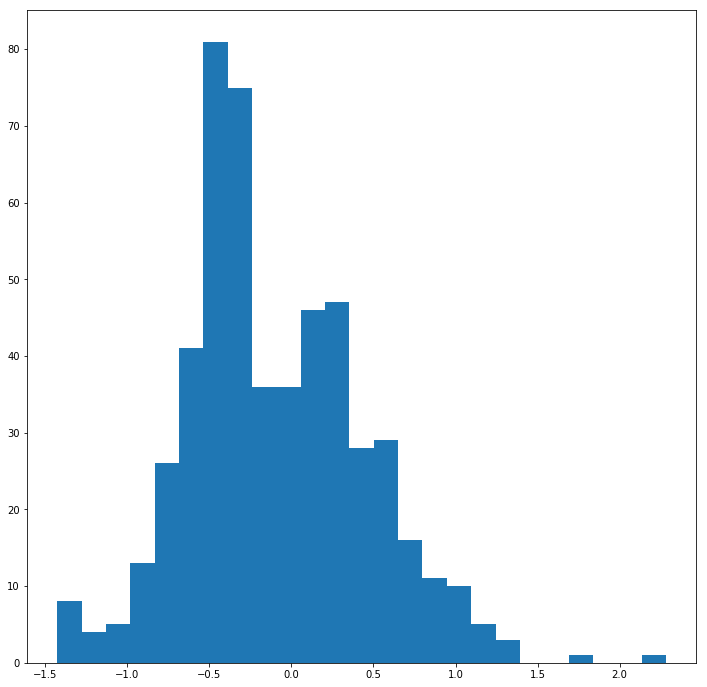

In [5]:
##########################
### Salaris Correction ###
##########################
cm_gcs = cln_gcs['C_FE'] + cln_gcs['FE_H'] - cln_gcs['M_H']
nm_gcs = cln_gcs['N_FE'] + cln_gcs['FE_H'] - cln_gcs['M_H']
newalpha = np.log10(10**cln_gcs['ALPHA_M']+10**cm_gcs+10**nm_gcs)

plt.figure(figsize=[12,12])
plt.hist(cln_gcs['M_H']+np.log(0.638*(10**(newalpha))+0.362),bins=25)

In [6]:
##############
### Models ###
##############

'''
x1: logT
x2: K
x3: feh
x4: logg
'''

#PARSEC
def parfit(x1,x2,x3,x4):
    p = [19.57711154,  1.62799079,  4.41723963,  0.24957004, -7.04845086, -0.39628751,\
 -0.5399325,   0.11835753,  0.05859978,  0.63493432]
    return p[0]+p[1]*x1+p[2]*x2+p[3]*x3+p[4]*x4+p[5]*np.multiply(x1,x2)+p[6]*np.multiply(x2,x4)+\
p[7]*(x2**2)+p[8]*(x3**2)+p[9]*(x4**2)

#BaSTI
def basfit(x1,x2,x3,x4):
    p = [13.03460029,  3.79689403,  3.32584733,  0.25049076, -7.74881108, -0.63878214,\
         0.13973642,  0.05510403,  0.7028039 ]
    return p[0]+p[1]*x1+p[2]*x2+p[3]*x3+p[4]*x4+p[5]*np.multiply(x2,x4)+p[6]*(x2**2)+p[7]*(x3**2)+p[8]*(x4**2)

#MIST
def misfit(x1,x2,x3,x4):
    p = [13.32819671,  3.72902784,  3.32282576,  0.27019356, -7.7639264,  -0.63399847,\
         0.1385912,   0.06873755,  0.70001738]
    return p[0]+p[1]*x1+p[2]*x2+p[3]*x3+p[4]*x4+p[5]*np.multiply(x2,x4)+p[6]*(x2**2)+p[7]*(x3**2)+p[8]*(x4**2)

In [25]:
cln_gcs.columns

<TableColumns names=('APSTAR_ID','TARGET_ID','ASPCAP_ID','FILE','APOGEE_ID','TELESCOPE','LOCATION_ID','FIELD','J','J_ERR','H','H_ERR','K','K_ERR','RA','DEC','GLON','GLAT','APOGEE_TARGET1','APOGEE_TARGET2','APOGEE_TARGET3','APOGEE2_TARGET1','APOGEE2_TARGET2','APOGEE2_TARGET3','TARGFLAGS','SURVEY','PROGRAMNAME','NINST','NVISITS','COMBTYPE','COMMISS','SNR','STARFLAG','STARFLAGS','ANDFLAG','ANDFLAGS','VHELIO_AVG','VSCATTER','VERR','VERR_MED','OBSVHELIO_AVG','OBSVSCATTER','OBSVERR','OBSVERR_MED','SYNTHVHELIO_AVG','SYNTHVSCATTER','SYNTHVERR','SYNTHVERR_MED','RV_TEFF','RV_LOGG','RV_FEH','RV_ALPHA','RV_CARB','RV_CCFWHM','RV_AUTOFWHM','SYNTHSCATTER','STABLERV_CHI2','STABLERV_RCHI2','CHI2_THRESHOLD','STABLERV_CHI2_PROB','MEANFIB','SIGFIB','SNREV','APSTAR_VERSION','ASPCAP_VERSION','RESULTS_VERSION','EXTRATARG','MIN_H','MAX_H','MIN_JK','MAX_JK','PARAM','FPARAM','PARAM_COV','FPARAM_COV','TEFF','TEFF_ERR','LOGG','LOGG_ERR','VMICRO','VMACRO','VSINI','M_H','M_H_ERR','ALPHA_M','ALPHA_M_ERR','ASPCAP_CHI

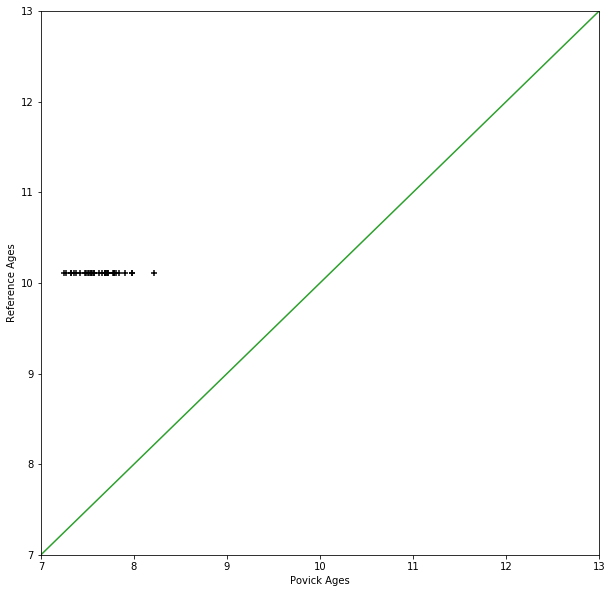

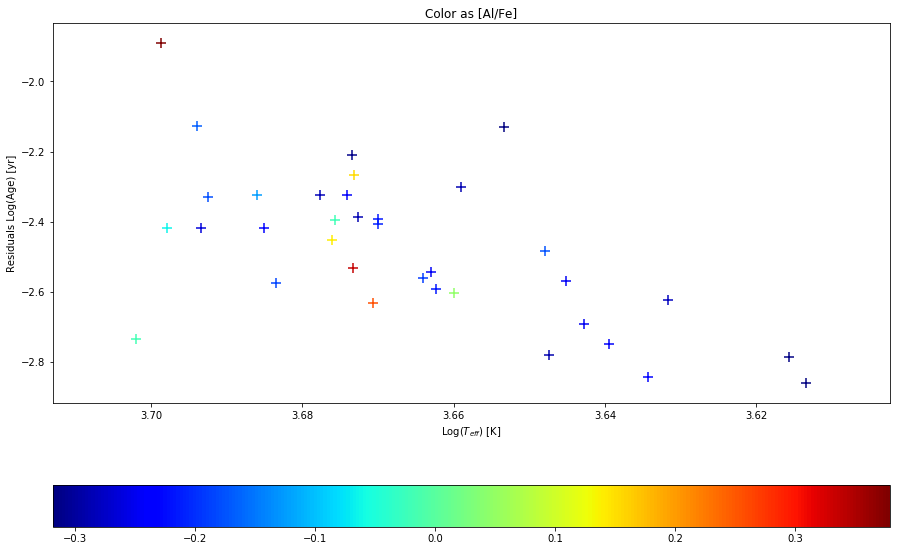

<TableColumns names=('APSTAR_ID','TARGET_ID','ASPCAP_ID','FILE','APOGEE_ID','TELESCOPE','LOCATION_ID','FIELD','J','J_ERR','H','H_ERR','K','K_ERR','RA','DEC','GLON','GLAT','APOGEE_TARGET1','APOGEE_TARGET2','APOGEE_TARGET3','APOGEE2_TARGET1','APOGEE2_TARGET2','APOGEE2_TARGET3','TARGFLAGS','SURVEY','PROGRAMNAME','NINST','NVISITS','COMBTYPE','COMMISS','SNR','STARFLAG','STARFLAGS','ANDFLAG','ANDFLAGS','VHELIO_AVG','VSCATTER','VERR','VERR_MED','OBSVHELIO_AVG','OBSVSCATTER','OBSVERR','OBSVERR_MED','SYNTHVHELIO_AVG','SYNTHVSCATTER','SYNTHVERR','SYNTHVERR_MED','RV_TEFF','RV_LOGG','RV_FEH','RV_ALPHA','RV_CARB','RV_CCFWHM','RV_AUTOFWHM','SYNTHSCATTER','STABLERV_CHI2','STABLERV_RCHI2','CHI2_THRESHOLD','STABLERV_CHI2_PROB','MEANFIB','SIGFIB','SNREV','APSTAR_VERSION','ASPCAP_VERSION','RESULTS_VERSION','EXTRATARG','MIN_H','MAX_H','MIN_JK','MAX_JK','PARAM','FPARAM','PARAM_COV','FPARAM_COV','TEFF','TEFF_ERR','LOGG','LOGG_ERR','VMICRO','VMACRO','VSINI','M_H','M_H_ERR','ALPHA_M','ALPHA_M_ERR','ASPCAP_CHI

In [39]:
##################
### Cal PARSEC ###
##################

M10 = np.where(cln_gcs['CLUSTER']=='M10')

absK = absmag(cln_gcs['K'],cln_gcs['DIST'],False)-cln_gcs['AK_TARG']

cm_gcs = cln_gcs['C_FE'] + cln_gcs['FE_H'] - cln_gcs['M_H']
nm_gcs = cln_gcs['N_FE'] + cln_gcs['FE_H'] - cln_gcs['M_H']
newalpha = np.log10(10**cln_gcs['ALPHA_M']+10**cm_gcs+10**nm_gcs)
salfeh = sal(cln_gcs['M_H'],newalpha)

parage = parfit(np.log10(cln_gcs['TEFF']),absK,salfeh,cln_gcs['LOGG'])

plt.figure(figsize=[10,10])
plt.scatter(parage[M10],np.log10(cln_gcs['AGE'][M10]*(10**9)),c='k',marker='+')
plt.plot([7,8,9,10,11,12,13],[7,8,9,10,11,12,13],c='tab:green')
plt.ylim(7,13)
plt.xlim(7,13)
plt.xlabel(r'Povick Ages')
plt.ylabel(r'Reference Ages')
plt.show()

plt.figure(figsize=[15,10])
plt.scatter(np.log10(cln_gcs['TEFF'][M10]),(parage[M10]-np.log10(cln_gcs['AGE'][M10]*(10**9))),c=cln_gcs['AL_FE'][M10],marker='+',\
            s=100,cmap='jet')
plt.gca().invert_xaxis()
plt.colorbar(orientation='horizontal')
plt.title(r'Color as [Al/Fe]')
plt.xlabel(r'Log($T_{eff})$ [K]')
plt.ylabel(r'Residuals Log(Age) [yr]')
plt.show()
cln_gcs.columns

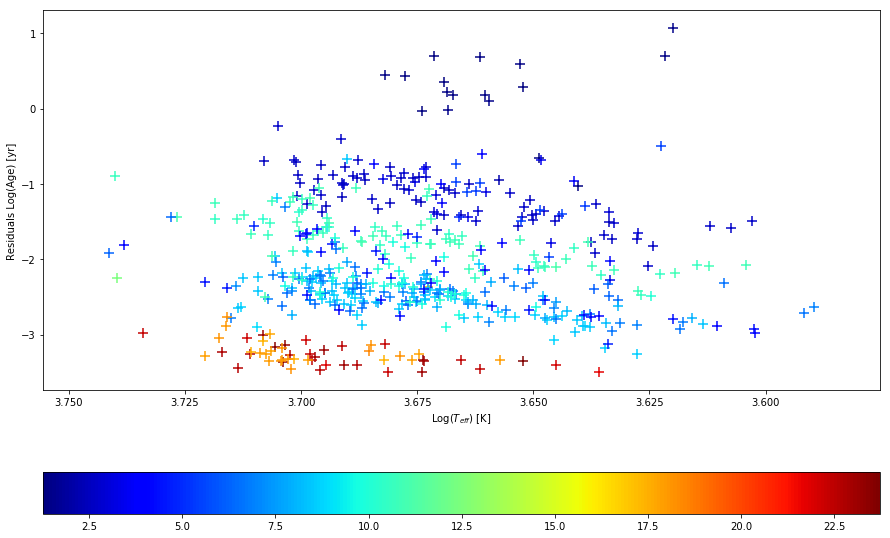

In [55]:
plt.figure(figsize=[15,10])
plt.scatter(np.log10(cln_gcs['TEFF']),(parage-np.log10(cln_gcs['AGE']*(10**9))),\
            c=np.sqrt(cln_gcs['GAIA_PMRA']**2+cln_gcs['GAIA_PMDEC']**2),marker='+',\
            s=100,cmap='jet')
plt.gca().invert_xaxis()
plt.colorbar(orientation='horizontal')
#plt.title(r'Color as [Al/Fe]')
plt.xlabel(r'Log($T_{eff})$ [K]')
plt.ylabel(r'Residuals Log(Age) [yr]')
plt.show()

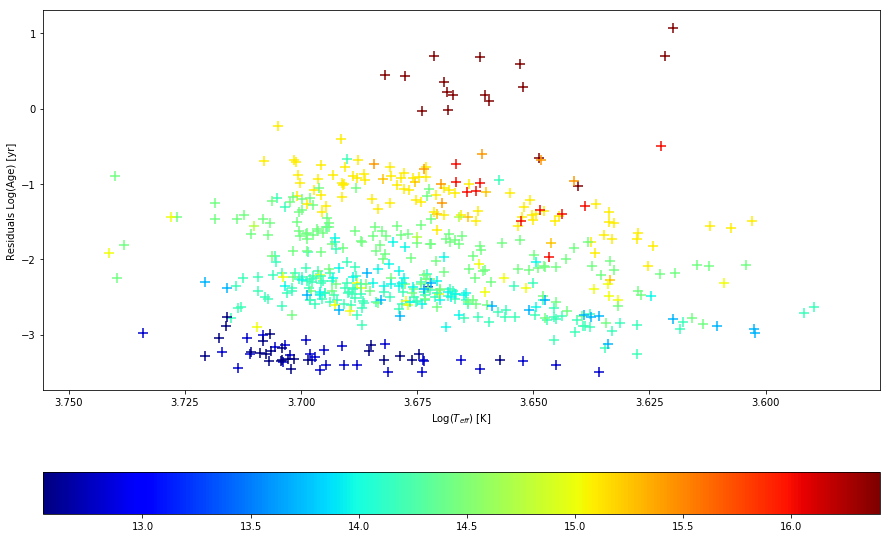

In [66]:
plt.figure(figsize=[15,10])
plt.scatter(np.log10(cln_gcs['TEFF']),(parage-np.log10(cln_gcs['AGE']*(10**9))),\
            c=cln_gcs['DIST'],marker='+',\
            s=100,cmap='jet')
plt.gca().invert_xaxis()
plt.colorbar(orientation='horizontal')
#plt.title(r'Color as [Al/Fe]')
plt.xlabel(r'Log($T_{eff})$ [K]')
plt.ylabel(r'Residuals Log(Age) [yr]')
plt.show()

In [8]:
############################
### PARSEC Uncertainties ###
############################

devs = []

for i in range(len(cln_gcs)):
    lgT = np.log10(cln_gcs['TEFF'][i])
    lgTERR = 0.434*(np.log(cln_gcs['TEFF_ERR'][i])/np.log10(cln_gcs['TEFF'][i]))
    ks = absK[i]
    ksERR = cln_gcs['K_ERR'][i]
    mh = cln_gcs['M_H'][i]
    mhERR = cln_gcs['M_H_ERR'][i]
    am = cln_gcs['ALPHA_M'][i]
    amERR = cln_gcs['ALPHA_M_ERR'][i]
    cfe = cln_gcs['C_FE'][i]
    cfeERR = cln_gcs['C_FE_ERR'][i]
    nfe = cln_gcs['N_FE'][i]
    nfeERR = cln_gcs['N_FE_ERR'][i]
    feh = cln_gcs['FE_H'][i]
    fehERR = cln_gcs['FE_H_ERR'][i]
    lgg = cln_gcs['LOGG'][i]
    lggERR = cln_gcs['LOGG_ERR'][i]
    
    ages = []
    for j in range(1000):
        nlgT,nks,nmh,nam,nlgg = noisydata(lgT,lgTERR,ks,ksERR,mh,mhERR,am,amERR,cfe,cfeERR,nfe,nfeERR,feh,\
                                          fehERR,lgg,lggERR)
        ages.append(parfit(nlgT,nks,sal(nmh,nam),nlgg))
    
    devs.append(mad(ages))

(array([382., 125.,   7.,   1.,   3.,   1.,   0.,   2.,   0.,   1.]),
 array([0.15246276, 0.2409109 , 0.32935903, 0.41780717, 0.5062553 ,
        0.59470344, 0.68315157, 0.77159971, 0.86004784, 0.94849598,
        1.03694411]),
 <a list of 10 Patch objects>)

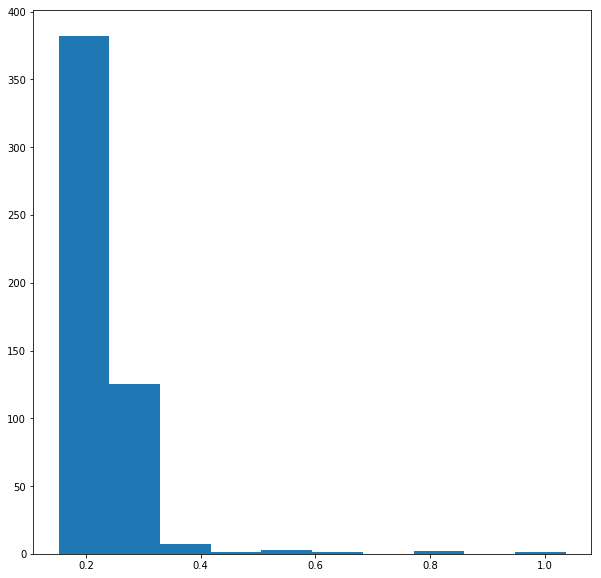

In [9]:
plt.figure(figsize=[10,10])
plt.hist(devs)

In [10]:
print(max(np.round(np.asarray(list(set(parage))),3)))
print(min(np.round(np.asarray(list(set(parage))),3)))
print(' ')
print(max(cln_gcs['AGE']))
print(min(cln_gcs['AGE']))

11.203
6.61
 
13.499
12.007


In [13]:
# plt.figure(figsize=[10,10])
# plt.scatter(10**logiso[rgb]['logTe'],logiso[rgb]['logg'],c=np.log10(logiso['Zini'][rgb]/0.02),cmap='jet',\
#             alpha=0.05)
# plt.scatter(cln_gcs[M10]['TEFF'],cln_gcs[M10]['LOGG'],c=cln_gcs['FE_H'][M10],cmap='jet')
# plt.gca().invert_yaxis()
# plt.gca().invert_xaxis()
# plt.xlabel('T')
# plt.ylabel('Log(g)')
# plt.title('Color as [Fe/H]')

# plt.figure(figsize=[10,10])
# plt.scatter(logiso[rgb]['Jmag']-logiso[rgb]['Ksmag'],logiso[rgb]['Ksmag'],c=np.log10(logiso['Zini'][rgb]/0.02),cmap='jet',alpha=0.1)
# plt.scatter(cln_gcs['J'][M10]-cln_gcs['K'][M10],cln_absK[M10],c=cln_gcs['FE_H'][M10],cmap='jet',s=10)
# plt.colorbar()
# plt.gca().invert_yaxis()
# plt.ylabel('K')
# plt.xlabel('J-K')
# # plt.xlabel('T')
# # plt.ylabel('Log(g)')
# plt.title('Color as [Fe/H]')

In [ ]:
max(absK)

In [14]:
#################
### Cal BaSTI ###
#################

# absK = absmag(cln_gcs['K'],cln_dist,False)-cln_gcs['AK_TARG']
# salfeh = sal(cln_gcs['M_H'],cln_gcs['ALPHA_M'])
# basti_age = bestbasti(np.log10(cln_gcs['TEFF']),absK,salfeh,cln_gcs['LOGG'])

# plt.figure(figsize=[10,10])
# plt.scatter(basti_age[first],cln_age[first],c='k',marker='+')
# plt.plot([7,8,9,10,11,12,13],[7,8,9,10,11,12,13],c='tab:green')
# plt.ylim(7,13)
# plt.xlim(7,13)
# plt.xlabel(r'Povick Ages')
# plt.ylabel(r'Reference Ages')
# plt.show()

# plt.figure(figsize=[15,10])
# plt.scatter(np.log10(cln_gcs['TEFF'])[first],(basti_age-np.log10(gc_age[cln]*(10**9)))[first],c=cln_gcs['FE_H'][first],marker='+',s=100,cmap='jet')
# plt.gca().invert_xaxis()
# plt.colorbar(orientation='horizontal')
# plt.title(r'Color as [Fe/H]')
# plt.xlabel(r'Log($T_{eff})$ [K]')
# plt.ylabel(r'Residuals Log(Age) [yr]')
# plt.show()

In [ ]:
################
### Cal MIST ###
################

# absK = absmag(cln_gcs['K'],cln_dist,False)-cln_gcs['AK_TARG']
# salfeh = sal(cln_gcs['M_H'],cln_gcs['ALPHA_M'])
# mist_age = bestmist(np.log10(cln_gcs['TEFF']),absK,salfeh,cln_gcs['LOGG'])

# plt.figure(figsize=[10,10])
# plt.scatter(mist_age[first],cln_age[first],c='k',marker='+')
# plt.plot([7,8,9,10,11,12,13],[7,8,9,10,11,12,13],c='tab:green')
# plt.ylim(7,13)
# plt.xlim(7,13)
# plt.xlabel(r'Povick Ages')
# plt.ylabel(r'Reference Ages')
# plt.title(r'Age to Age')
# plt.show()

# plt.figure(figsize=[15,10])
# plt.scatter(np.log10(cln_gcs['TEFF'])[first],(mist_age-np.log10(gc_age[cln]*(10**9)))[first],c=cln_gcs['FE_H'][first],marker='+',s=100,cmap='jet')
# plt.gca().invert_xaxis()
# plt.colorbar(orientation='horizontal')
# plt.title(r'Color as [Fe/H]')
# plt.xlabel(r'Log($T_{eff})$ [K]')
# plt.ylabel(r'Residuals Log(Age) [yr]')
# plt.show()

In [ ]:
print(gcs['CLUSTER'][M10])

In [ ]:
Table(gcs).show_in_browser(jsviewer=True)

In [ ]:
cluster_ages = {'47TUC':-9999.0,'M10':12.846,'M107':13.477,'M12':13.496,'M13':13.094,'M15':13.499,'M2':-9999.0,\
                'M3':12.585,'M4':12.966,'M5':12.007,'M53':13.498,'M55':13.498,'M68':12.803,'M71':13.493,\
                'M79':-9999.0,'M92':13.498,'N1851':-9999.0,'N2808':-9999.0,'N3201':12.836,'N362':-9999.0,\
                'N4147':13.261,'N5053':13.493,'N5466':13.410,'N6229':-9999.0,'N6388':-9999.0,'N6397':13.496,\
                'N6752':-9999.0,'OCEN':-9999.0}

ages = []
for i in range(len()):
    ages.append()

In [ ]:
[*set(gcs['CLUSTER']),]

In [ ]:
parsec['int_IMF'][rgb]

In [ ]:
min(cln_gcs['LOGG'])